In [1]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# imaging
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tf.__version__: 2.8.0
keras.__version__: 2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [23]:
path = '/content/drive/MyDrive/Colab\ Notebooks/autonomous_car'

# Only run on fresh Colab start, gets data from Drive and unzips.
!cp -r {path}/data/training_data.zip /content/data/
!cp -r {path}/data/test_data.zip /content/data/
!cp -r {path}/data/training_norm.csv /content/data/

import zipfile
with zipfile.ZipFile('data/training_data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

with zipfile.ZipFile('data/test_data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [4]:
def load_training():
    labels = pd.read_csv('data/training_norm.csv')

    images_dir = 'data/training_data/'

    X = []
    Y = []

    pattern = '*.png'

    for label in labels.itertuples():
        filename = str(label.image_id) + '.png'

        if fnmatch.fnmatch(filename, pattern):
            X.append(os.path.join(images_dir, filename))
            Y.append([label.angle, label.speed])

    return X, Y

In [5]:
def load_test():
    images_dir = 'data/test_data/'
    filenames = os.listdir(images_dir)

    paths = []
    for filename in filenames:
        if fnmatch.fnmatch(filename, '*.png'):
            paths.append(os.path.join(images_dir, filename))

    return paths

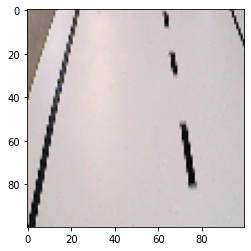

In [6]:
# Preprocess images
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    #image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (100, 100))
    image = image / 255 # normalizing
    return image

def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

image = read_image(load_training()[0][2])
plt.imshow(img_preprocess(image))

def image_data_generator(image_paths, labels, batch_size, is_training):
    batch_images = []
    batch_labels = []

    while True:
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            image = read_image(image_paths[random_index])
            image = img_preprocess(image)

            batch_images.append(image)
            batch_labels.append(labels[random_index])
        
        yield(np.asarray(batch_images), np.asarray(batch_labels))


In [7]:
model_output_dir = 'model_output/'

In [8]:
base_model = tf.keras.applications.InceptionResNetV2(
        input_shape=(100,100,3),
        weights="imagenet",
        include_top=False
    )
base_model.trainable = False

inputs = keras.Input(shape=(100, 100, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = keras.layers.Dense(2)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 3,074
Non-trainabl

In [22]:
%load_ext tensorboard
import datetime

!rm -rf ./logs/

%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3916), started 11:48:43 ago. (Use '!kill 3916' to kill it.)

<IPython.core.display.Javascript object>

In [10]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check.h5'), verbose=1, save_best_only=True)

x, y = load_training()

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(x_train), len(x_valid)))

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(image_data_generator(x_train, y_train, batch_size=24, is_training=True),
                              steps_per_epoch=50,
                              epochs=10,
                              validation_data = image_data_generator(x_valid, y_valid, batch_size=24, is_training=False),
                              validation_steps=50,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback, tensorboard_callback])

# # # always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'self-drive.h5'))

Training data: 11034
Validation data: 2759
Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 1.0136
Epoch 1: val_loss improved from inf to 0.36541, saving model to model_output/lane_navigation_check.h5
50/50 [==============================] - 306s 6s/step - loss: 1.0136 - val_loss: 0.3654
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.6531
Epoch 2: val_loss improved from 0.36541 to 0.21445, saving model to model_output/lane_navigation_check.h5
50/50 [==============================] - 565s 11s/step - loss: 0.6531 - val_loss: 0.2144
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.4619 
Epoch 3: val_loss improved from 0.21445 to 0.14901, saving model to model_output/lane_navigation_check.h5
50/50 [==============================] - 817s 17s/step - loss: 0.4619 - val_loss: 0.1490
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.3241 
Epoch 4: val_loss improved from 0.14901 to 0.11329, saving model to model_o

ResourceExhaustedError: ignored

In [24]:
#filepath = "model_output/lane_navigation_check.h5"

#reconstructed_model = keras.models.load_model("lane_navigation_check.h5")

#np.testing.assert_allclose(model.predict(image_data_generator(x_train, y_train, batch_size=24, is_training=True), 
#                reconstructed_model.predict((image_data_generator(x_train, y_train, 
#                batch_size=24, is_training=True)))

#new_history= reconstructed_model.fit(image_data_generator(x_train, y_train, batch_size=24, is_training=True),
#                              steps_per_epoch=50,
#                              epochs=10,
#                              validation_data = image_data_generator(x_valid, y_valid, batch_size=24, is_training=False),
#                              validation_steps=50,
#                              verbose=1,
#                              shuffle=1,
#                              callbacks=[checkpoint_callback, tensorboard_callback])

#reconstructed_model.save(os.path.join(model_output_dir,'self-drive.h5'))


# Prepare a directory to store all the checkpoints.
checkpoint_dir = "model_output/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(image_data_generator(x_train, y_train, batch_size=24, is_training=True),
                              steps_per_epoch=50,
                              epochs=5,
                              validation_data = image_data_generator(x_valid, y_valid, batch_size=24, is_training=False),
                              validation_steps=50,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback, tensorboard_callback])

Restoring from model_output//lane_navigation_check.h5
Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.0481
Epoch 1: val_loss did not improve from 0.05010
50/50 [==============================] - 60s 1s/step - loss: 0.0481 - val_loss: 0.0566
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.0453
Epoch 2: val_loss did not improve from 0.05010
50/50 [==============================] - 139s 3s/step - loss: 0.0453 - val_loss: 0.0528
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.0469
Epoch 3: val_loss improved from 0.05010 to 0.04944, saving model to model_output/lane_navigation_check.h5
50/50 [==============================] - 228s 5s/step - loss: 0.0469 - val_loss: 0.0494
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.0479
Epoch 4: val_loss improved from 0.04944 to 0.04703, saving model to model_output/lane_navigation_check.h5
50/50 [==============================] - 319s 6s/step - loss: 0.0479 - val_loss: 

In [27]:
model.save(os.path.join(model_output_dir,'self-drive.h5'))

In [28]:
history = model.history
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

_, categorical_acc = model.evaluate(y_train)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

NameError: ignored

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/self-drive.h5')
    prediction = model.predict(X)
    summarize_prediction(Y, prediction)
    return prediction

n_tests = 1000
x_test, y_test = next(image_data_generator(x_valid, y_valid, n_tests, False))
y_pred = predict_and_summarize(x_test, y_test)

mse       = 0.045
r_squared = 52.57%


In [53]:
model = load_model(f'{model_output_dir}/self-drive.h5')
        
def compute_steering_angle(model, frame):
    x = np.asarray([img_preprocess(frame)])
    
    # Return array [angle, speed]
    return model.predict(x)[0]

x_test = load_test()

print(x_test[0])

predicted_angles = []
predicted_speeds = []
image_ids = []


for image_path in x_test:
    prediction = compute_steering_angle(model, read_image(image_path))
    

    angle = prediction[0]
    speed = prediction[1]

    predicted_angles.append(prediction[0])
    if prediction[1] < 0.5:
      predicted_speeds.append(0)
    else:
      predicted_speeds.append(1)



    image_ids.append(os.path.basename(image_path).split('.')[0])

data/test_data/140.png


In [54]:
from natsort import natsort_keygen

data = {
    'image_id': image_ids,
    'angle': predicted_angles,
    'speed': predicted_speeds
}
results = pd.DataFrame(data)
results.sort_values('image_id', inplace=True, key=natsort_keygen())
print(results.head(100))

    image_id     angle  speed
959        1  0.640871      0
421        2  0.677241      1
112        3  0.154672      1
972        4  0.289343      1
797        5  0.064240      1
..       ...       ...    ...
816       96  0.366249      0
593       97  0.344305      0
187       98  0.611126      0
223       99  0.486729      1
732      100  0.662740      1

[100 rows x 3 columns]


In [55]:
results.to_csv('results.csv', index=False)

In [56]:
print(results.at[20, 'image_id'])
print(results.at[20, 'angle'])
results.at[20, 'speed']

587
0.7805456


0